In [1]:
from transformers import SwinConfig, AutoConfig, AutoImageProcessor, SwinForImageClassification, AutoModelForImageClassification
from PIL import Image
import requests

import os
import pandas as pd
import numpy as np
# import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


import cv2
# from google.colab.patches import cv2_imshow

2024-02-26 16:59:59.321417: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-26 16:59:59.915216: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/medicalteam/anaconda3/envs/dang/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/medicalteam/anaconda3/envs/dang/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
use_colab = False
assert use_colab in [True, False]
is_train = True

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
if use_colab:
    base_path='/content/drive/MyDrive/2023 서울AI허브/Project/Real_data'
else:
    base_path='/home/medicalteam/바탕화면/민지/project/Real_data/datasets'

## data 확인

In [5]:
# label 확인
get_dir_list = os.listdir(base_path)
print(get_dir_list)

['Mild AD', 'Normal']


/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_0729_110816/plane0.png
<PIL.PngImagePlugin.PngImageFile image mode=L size=182x182 at 0x7F79AF3F4290>


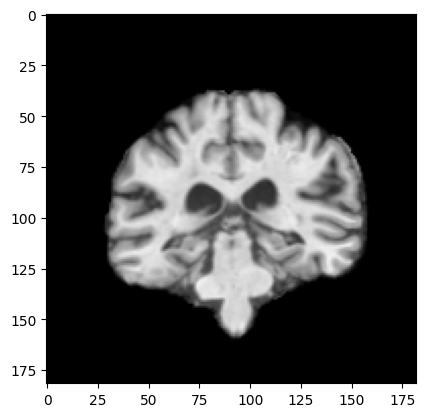

In [6]:
## image 예시
img_path = base_path + '/Mild AD/002_S_0729_110816/plane0.png'
# plan0~29
print(img_path)

image = Image.open(img_path)
print(image)

img = cv2.imread(img_path)
plt.imshow(img)
# size=182x182

## dataset

In [7]:
# label list
dir_list = ['Mild AD', 'Normal']

get_idx_lable = {}
get_label_idx = []
for idx, lable in enumerate(dir_list):
    get_idx_lable[lable] = idx
    get_label_idx.append(lable)
print(get_idx_lable)
print(get_label_idx)

{'Mild AD': 0, 'Normal': 1}
['Mild AD', 'Normal']


In [8]:
# datalist, label
get_all_datalist, get_all_label = [], []
for get_dir in dir_list:
    get_dir_path = os.path.join(base_path, get_dir)
    get_subject_list = os.listdir(get_dir_path)
    for get_subject in get_subject_list:
        get_subject_path = os.path.join(get_dir_path, get_subject)
        get_file_list = os.listdir(get_subject_path)
        for get_file in get_file_list:
          if get_file.endswith('.png'):
            get_file_path = os.path.join(get_subject_path, get_file)
            get_all_datalist.append(get_file_path)
            lable = get_file_path.split("/")[-3]
            get_all_label.append(lable)

print(get_all_datalist)
print(set(get_all_label))

['/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane9.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane26.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane16.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane19.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane21.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane17.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane27.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane0.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane3.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane15.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/

In [9]:
# final_df
final_df = pd.DataFrame({
    'data_path': get_all_datalist,
    'label': get_all_label
})

print(final_df.info())
print(final_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19230 entries, 0 to 19229
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data_path  19230 non-null  object
 1   label      19230 non-null  object
dtypes: object(2)
memory usage: 300.6+ KB
None
                                           data_path    label
0  /home/medicalteam/바탕화면/민지/project/Real_data/da...  Mild AD
1  /home/medicalteam/바탕화면/민지/project/Real_data/da...  Mild AD
2  /home/medicalteam/바탕화면/민지/project/Real_data/da...  Mild AD
3  /home/medicalteam/바탕화면/민지/project/Real_data/da...  Mild AD
4  /home/medicalteam/바탕화면/민지/project/Real_data/da...  Mild AD


In [10]:
# label_object to int
final_df['label'] = final_df['label'].map(get_idx_lable)

print(final_df.info())
print(final_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19230 entries, 0 to 19229
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data_path  19230 non-null  object
 1   label      19230 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 300.6+ KB
None
                                           data_path  label
0  /home/medicalteam/바탕화면/민지/project/Real_data/da...      0
1  /home/medicalteam/바탕화면/민지/project/Real_data/da...      0
2  /home/medicalteam/바탕화면/민지/project/Real_data/da...      0
3  /home/medicalteam/바탕화면/민지/project/Real_data/da...      0
4  /home/medicalteam/바탕화면/민지/project/Real_data/da...      0


In [11]:
# data split
train_data, valid_data, train_labels, valid_labels = \
    train_test_split(final_df['data_path'], final_df['label'], test_size=0.2, random_state=42)
train_data, test_data, train_labels, test_labels = \
    train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
"""
train_data, train_labels 0.6
valid_data, valid_labels 0.2
test_data, test_labels 0.2
"""
print(train_data.shape, train_labels.shape)
print(valid_data.shape, valid_labels.shape)
print(test_data.shape, test_labels.shape)

(12307,) (12307,)
(3846,) (3846,)
(3077,) (3077,)


In [12]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data.values.tolist()  # list 형태로 입력
        self.labels = labels.values.tolist()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]  # Get image path from the dataframe
        label = self.labels[idx]     # Get label from the dataframe

        # Load image
        image = Image.open(img_path)
        # print('image info before transform: %s' %(image))

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
            # print(f'image info after transform: {image.shape}')

        return image, label

In [13]:
# Define batch_size
batch_size = 30

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the desired size
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),           # Convert images to tensors
    # transforms.RandomRotation(10),
    # transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    # transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize pixel values
    # transforms.ToPILImage(mode=None)
])

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the desired size
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),           # Convert images to tensors
#     transforms.RandomRotation(10),
#     transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    # transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize pixel values
    # transforms.ToPILImage(mode=None)
])

# Create dataset instances
train_dataset = CustomDataset(train_data, train_labels, transform=transform_train)
valid_dataset = CustomDataset(valid_data, valid_labels, transform=transform)
test_dataset = CustomDataset(test_data, test_labels, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [14]:
# dataset 확인
print('dataset len: %d' %(train_dataset.__len__()))
train_dataset.__getitem__(0)

dataset len: 12307


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 1)

In [15]:
# dataloader 확인
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(labels)

tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 0])


In [16]:
# # DataLoader가 올바르게 되었는지 검사
# for batch in train_loader:
#   break

tensor(0)


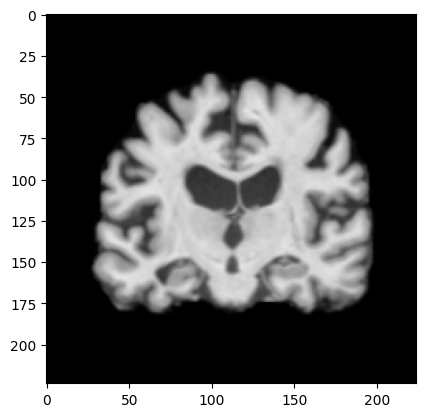

tensor(0)


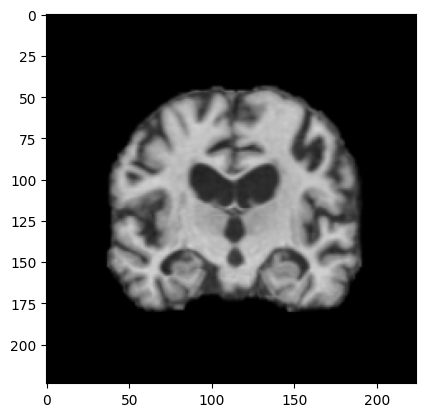

tensor(1)


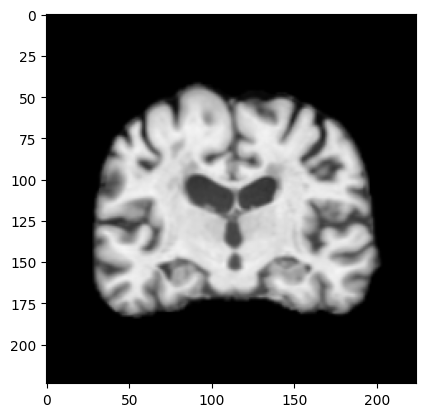

tensor(1)


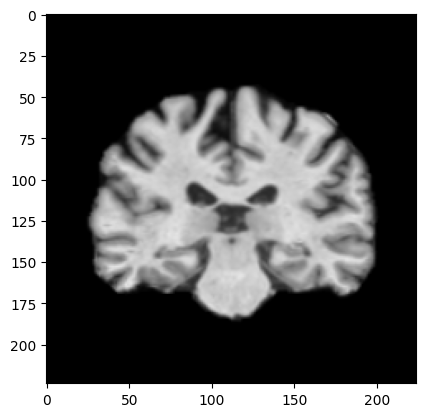

tensor(0)


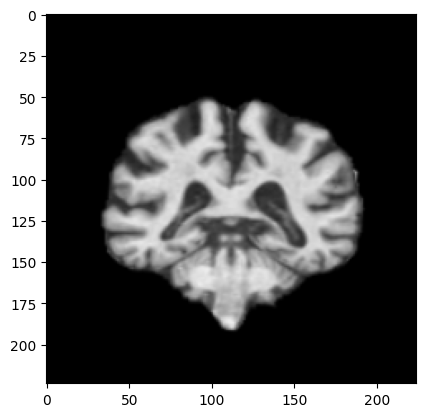

tensor(1)


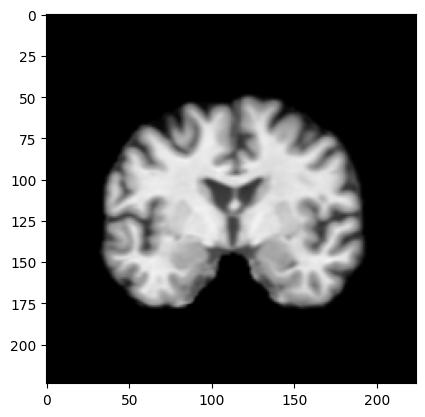

tensor(0)


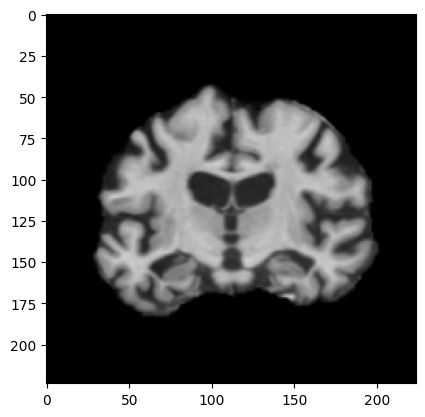

tensor(0)


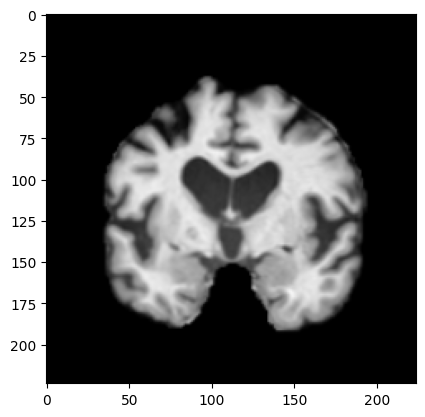

tensor(0)


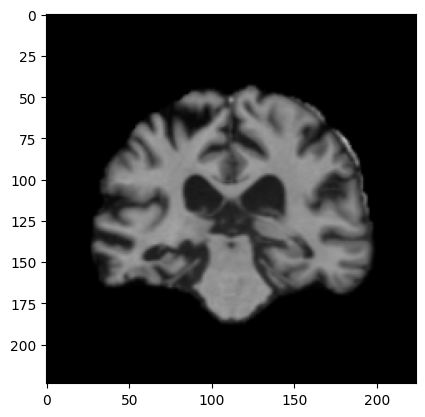

tensor(0)


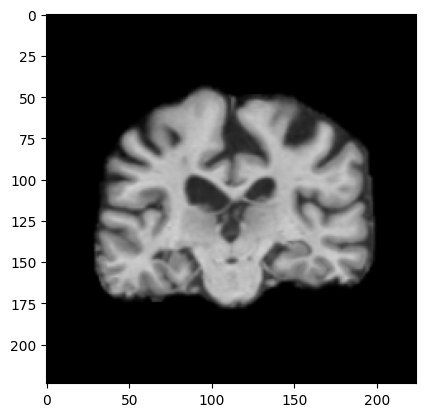

tensor(1)


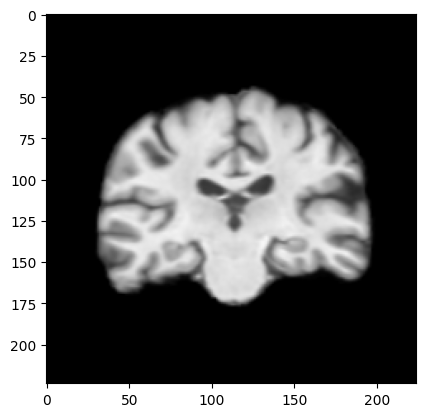

tensor(0)


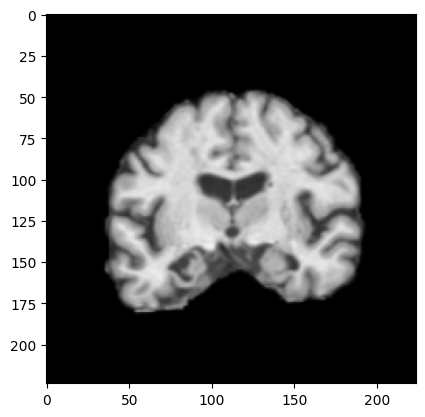

tensor(0)


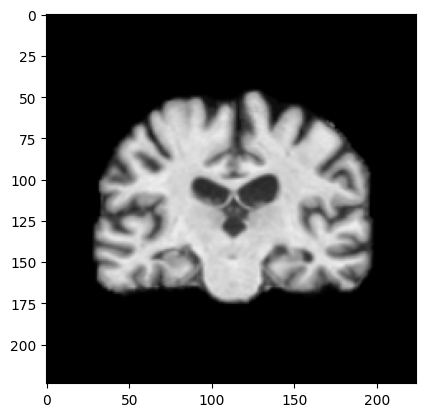

tensor(0)


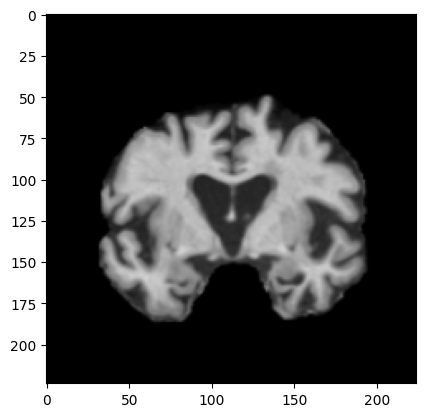

tensor(1)


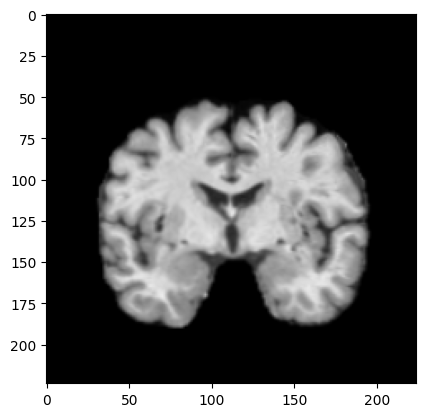

tensor(0)


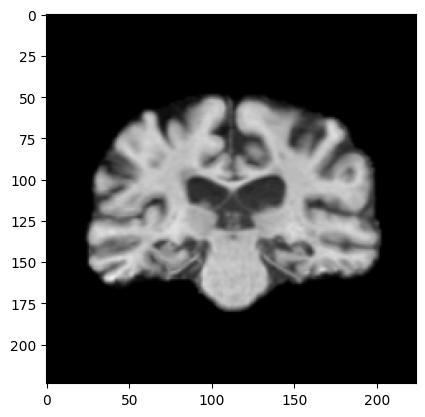

tensor(0)


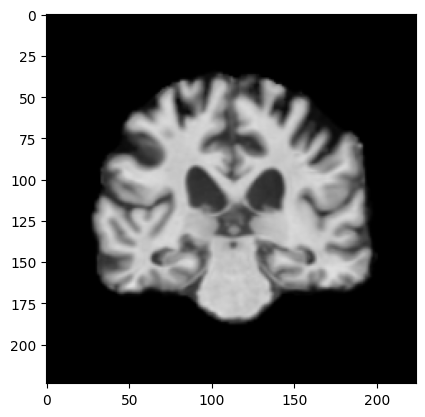

tensor(0)


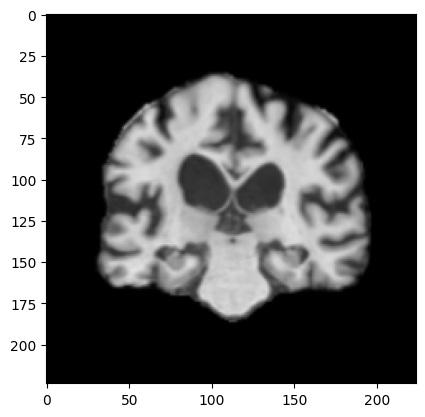

tensor(0)


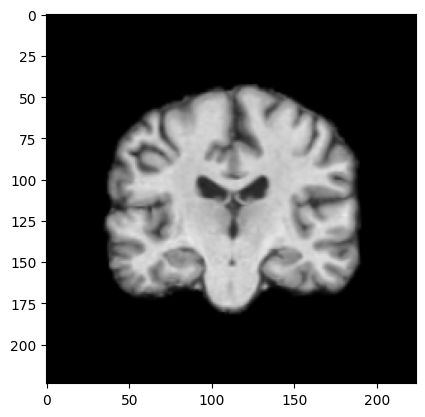

tensor(0)


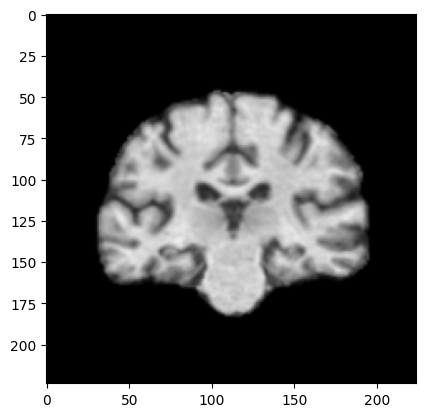

tensor(1)


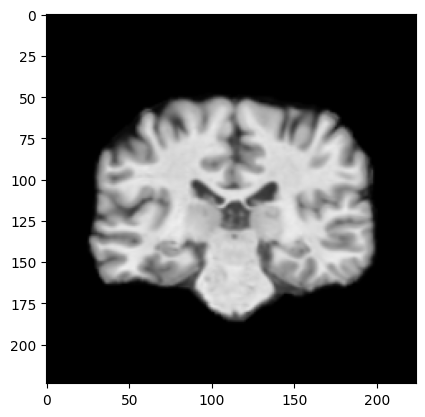

tensor(1)


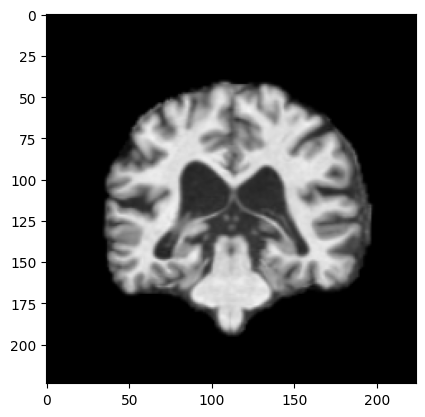

tensor(1)


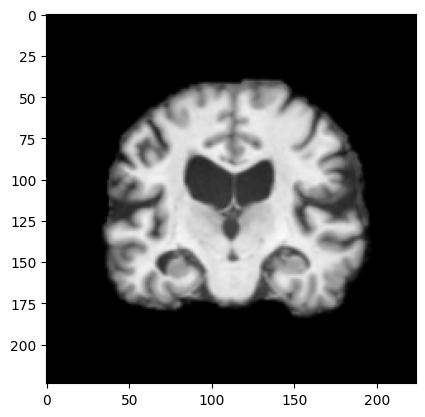

tensor(0)


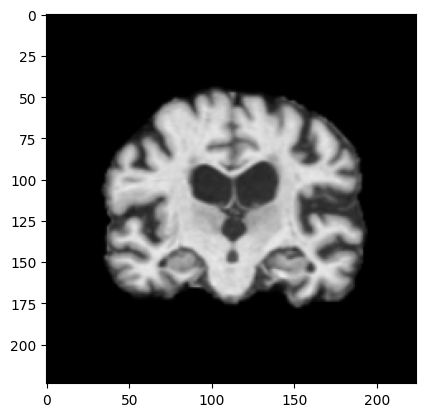

tensor(1)


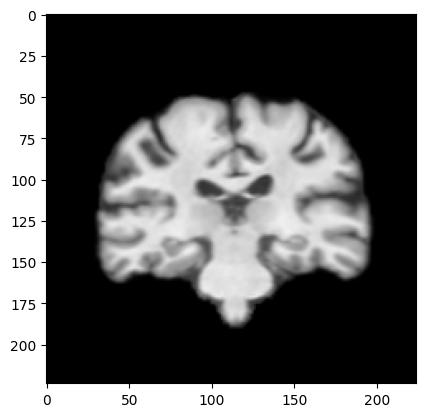

tensor(1)


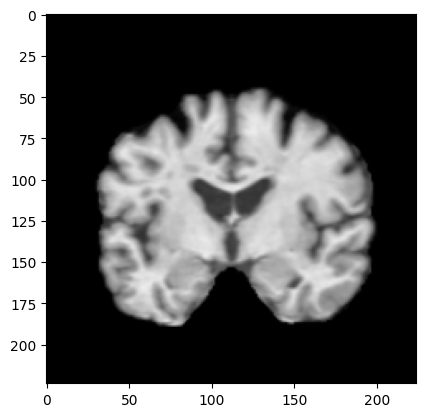

tensor(0)


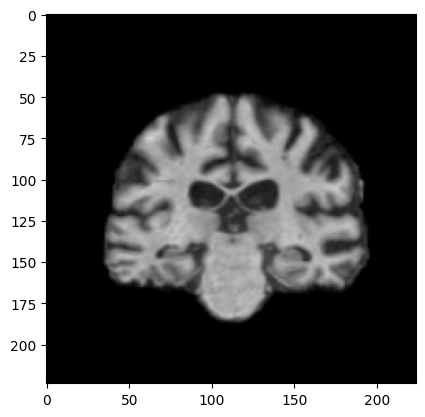

tensor(1)


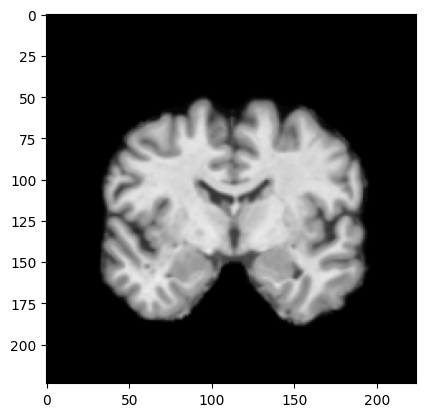

tensor(0)


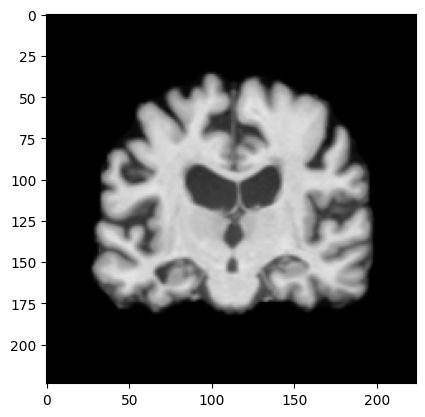

tensor(0)


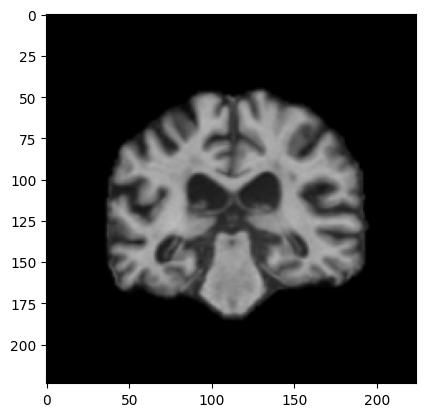

In [17]:
# 데이터 확인
def custom_imshow(img):
  img = img.numpy()
  plt.imshow(np.transpose(img, (1,2,0)))
  plt.show()

tensor = []
def process():
  for batch_idx, (images, labels) in enumerate(train_loader):
    for i in range (30):
      print(labels[i])
      tensor.append(images[i])
      custom_imshow(images[i])
    if batch_idx == 0:
      break

process()

In [18]:
for i in range(224):
  print(tensor[0][0][i])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0.,

In [19]:
# 레이블 인덱스 별 레이블 지정
labels = get_idx_lable
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
  label2id[label] = i
  id2label[i] = label

print('인덱스 별 레이블: ', id2label)
print('레이블 별 인덱스: ', label2id)

인덱스 별 레이블:  {0: 'Mild AD', 1: 'Normal'}
레이블 별 인덱스:  {'Mild AD': 0, 'Normal': 1}


In [20]:
## Tensorflow ver.
# train_idg = ImageDataGenerator(rescale=1./255,
#                                rotation_range=0.1,
#                                width_shift_range=0.1,
#                                height_shift_range=0.1,
#                                zoom_range=0.1,
#                                horizontal_flip=False,
#                                vertical_flip=False)

# valid_idg = ImageDataGenerator(rescale=1./255)
# test_idg = ImageDataGenerator(rescale=1./255)

In [21]:
## Tensorflow ver.
# train_generator = train_idg.flow_from_dataframe(dataframe=train_df,
#                                                 directory=None,
#                                                 x_col="data",
#                                                 y_col="label",
#                                                 class_mode="categorical",
#                                                 target_size=(224,224),
#                                                 batch_size=batch_size)

# valid_generator = test_idg.flow_from_dataframe(dataframe=valid_df,
#                                               directory=None,
#                                               x_col="data",
#                                               y_col="label",
#                                               class_mode="categorical",
#                                               target_size=(224,224),
#                                               batch_size=batch_size)

# test_generator = test_idg.flow_from_dataframe(dataframe=test_df,
#                                               directory=None,
#                                               x_col="data",
#                                               y_col="label",
#                                               class_mode="categorical",
#                                               target_size=(224,224),
#                                               batch_size=batch_size)

In [22]:
## Tensorflow ver.
# # 데이터셋에 저장된 이미지를 출력하는 함수
# # 이미지 확인을 위해 사용한다.
# def plotImages(images_arr):
#     fig, axes = plt.subplots(1, 5, figsize=(20,20))
#     axes = axes.flatten()
#     for img, ax in zip( images_arr, axes):
#         ax.imshow(img)
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

In [23]:
## Tensorflow ver.
# # generator 예시
# augmented_images = [train_generator[0][0][0] for i in range(5)]
# plotImages(augmented_images)

## model

In [24]:
# Initialize Swin Transformer model and image processor

model_name = "microsoft/swinv2-base-patch4-window16-256"
processor = AutoImageProcessor.from_pretrained(model_name, label2id=label2id, id2label=id2label) # 이미지를 patch로 잘라줌
# pretrained_model = AutoModelForImageClassification.from_pretrained(model_name)
configuration = SwinConfig()
# configuration = AutoConfig.from_pretrained(model_name)
configuration.num_labels = 2

# pretrained_model = SwinForImageClassification.from_pretrained(
#     model_name,
#     num_labels=2,
#     id2label=id2label,
#     label2id=label2id,
#     ignore_mismatched_sizes = True)
pretrained_model = SwinForImageClassification(configuration)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [25]:
# 모듈 이름 확인
for name, param in pretrained_model.base_model.named_parameters():
    if 'layernorm' in name:
      print(name)
    print(name, param.shape)

embeddings.patch_embeddings.projection.weight torch.Size([96, 3, 4, 4])
embeddings.patch_embeddings.projection.bias torch.Size([96])
embeddings.norm.weight torch.Size([96])
embeddings.norm.bias torch.Size([96])
encoder.layers.0.blocks.0.layernorm_before.weight
encoder.layers.0.blocks.0.layernorm_before.weight torch.Size([96])
encoder.layers.0.blocks.0.layernorm_before.bias
encoder.layers.0.blocks.0.layernorm_before.bias torch.Size([96])
encoder.layers.0.blocks.0.attention.self.relative_position_bias_table torch.Size([169, 3])
encoder.layers.0.blocks.0.attention.self.query.weight torch.Size([96, 96])
encoder.layers.0.blocks.0.attention.self.query.bias torch.Size([96])
encoder.layers.0.blocks.0.attention.self.key.weight torch.Size([96, 96])
encoder.layers.0.blocks.0.attention.self.key.bias torch.Size([96])
encoder.layers.0.blocks.0.attention.self.value.weight torch.Size([96, 96])
encoder.layers.0.blocks.0.attention.self.value.bias torch.Size([96])
encoder.layers.0.blocks.0.attention.outp

In [26]:
# for name, param in pretrained_model.base_model.named_parameters():
#     param.requires_grad = False
#     if 'layernorm' in name: # 마지막 layer만 수정
#       param.requires_grad = True

In [27]:
# # parameter freeze
# # pretrained model의 웨이트 고정 -> 안하면 오버피팅 가능성있음!
# # (1) 한거 안한거 비교해보기
# for param in pretrained_model.base_model.parameters():
#     param.requires_grad = False

In [28]:
# model 확인
print(pretrained_model)

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [29]:
class fine_tuned_model(nn.Module):
  def __init__(self, pretrained_model, get_label_idx):
    super(fine_tuned_model, self).__init__()
    self.label_num = len(get_label_idx)

    self.pretrained_model = pretrained_model
    # self.dense = nn.Sequential(
    #         # nn.Linear(in_features=2, out_features=4, bias=True),
    #         # nn.Linear(in_features=4, out_features=16, bias=True),
    #         # nn.Linear(in_features=16, out_features=self.label_num, bias=True)
    #         nn.Linear(in_features=2, out_features=self.label_num, bias=True)
    #     )

  def forward(self, **inputs):
    outputs = self.pretrained_model(**inputs)
    logits = outputs.logits
    # output = self.dense(logits)
    output = logits

    return output

# class ClassificationModel(nn.Module):
#     def __init__(self, pretrained_model='bert-base-uncased', num_labels=2):
#         super(ClassificationModel, self).__init__()
#         self.bert = BertModel.from_pretrained(pretrained_model)
#         self.linear = nn.Sequential(nn.Linear(768, 128),
#                                     nn.Tanh(),
#                                     nn.Linear(128, num_labels))

#     def forward(self, x):
#         all_hidden, pooler = self.bert(**x)
#         pooled_output = torch.mean(all_hidden, 1)
#         predict = self.linear(pooled_output)
#         return predict

In [30]:
# model 정의
model = fine_tuned_model(pretrained_model, get_label_idx)
# model = pretrained_model

In [31]:
# # model 확인
print("\n\n------Model------")
print(model)



------Model------
fine_tuned_model(
  (pretrained_model): SwinForImageClassification(
    (swin): SwinModel(
      (embeddings): SwinEmbeddings(
        (patch_embeddings): SwinPatchEmbeddings(
          (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        )
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): SwinEncoder(
        (layers): ModuleList(
          (0): SwinStage(
            (blocks): ModuleList(
              (0-1): 2 x SwinLayer(
                (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                (attention): SwinAttention(
                  (self): SwinSelfAttention(
                    (query): Linear(in_features=96, out_features=96, bias=True)
                    (key): Linear(in_features=96, out_features=96, bias=True)
                    (value): Linear(in_features=96, out_features=96, bias=True)
                    (dr

In [32]:
# %pip install wandb
import wandb
wandb.login

wandb.init(project="Memoria", entity='sasmco12', name='Swintransformer_base')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sasmco12. Use `wandb login --relogin` to force relogin


In [33]:
num_epochs = 10

In [34]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [35]:
# init config setting
wandb.config = {
  "learning_rate": 1e-4,
  "epochs": num_epochs,
  "batch_size": batch_size
}

In [36]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print(DEVICE)

cpu


In [37]:
# # 모델 직접 저장 예시
# model = torch.load('swintransformer.pt')

# 딕셔너리 형태 저장 예시
finalepoch = 4
ptpath = f'/home/medicalteam/바탕화면/민지/project/SwinTransformer_{finalepoch}.pt'
checkpoint = torch.load(ptpath)
model.load_state_dict(checkpoint) # state_dict 형태로 저장된 파라미터 불러오기

<All keys matched successfully>

In [ ]:

model.to(DEVICE)

save_interval = 1

model.train()
train_losses = []
valid_losses = []
step = 0

# Training loop
for epoch in range(num_epochs):
    losses = []
    print("\n Epoch {}/{}".format(epoch+1, num_epochs))
    for inputs, labels in tqdm(train_loader):
      inputs, labels = inputs, labels.to(DEVICE)
      optimizer.zero_grad()
      inputs = processor(images=inputs, return_tensors="pt", padding=True, do_resize=False, do_rescale=False, do_normalize=False).to(DEVICE)
        # pt: tensor로 반환
        # padding: 해당 batch가 가질 수 있는 가장 긴 길이로 padding
      outputs = model(**inputs)
      # logits = outputs.logits
      # # model predicts one of the classes
      # predictions = torch.argmax(logits, dim=-1)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      loss.backward()
      optimizer.step()

      step += 1

      # 평균 손실 출력 및 분류
      if (step + 1) % 1 == 0:
        print("Step {}: batch Mean Loss: {}".format(step, loss))
        wandb.log({'train_loss': loss})

    print("Epoch {}/{} This Loss is : {}".format(epoch+1, num_epochs, np.mean(losses)))
    train_losses.append(np.mean(losses))

    if (epoch + 1) % save_interval == 0:
      checkpoint_path = f'/home/medicalteam/바탕화면/민지/project/SwinTransformer_{epoch+5}.pt'
      torch.save(model.state_dict(), checkpoint_path)
      print(f"Saved model checkpoint for epoch {epoch+1}")

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs, labels.to(DEVICE)
            inputs = processor(images=inputs, return_tensors="pt", padding=True, do_resize=False, do_rescale=False, do_normalize=False).to(DEVICE)
            outputs = model(**inputs)
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss.item())
            wandb.log({'valid_loss': val_loss})

    print(f"Epoch {epoch + 1}: Train Loss {np.mean(losses)}, Validation Loss {np.mean(val_losses)}")


 Epoch 1/10


  0%|          | 0/411 [00:00<?, ?it/s]

Step 1: batch Mean Loss: 0.5481441617012024
Step 2: batch Mean Loss: 0.5066815614700317
Step 3: batch Mean Loss: 0.382519394159317
Step 4: batch Mean Loss: 0.4471127688884735
Step 5: batch Mean Loss: 0.9651567339897156
Step 6: batch Mean Loss: 0.6075353026390076


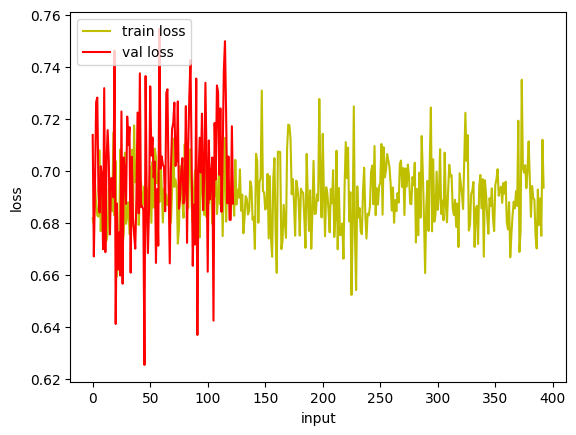

In [ ]:
# visualization
fig, loss_ax = plt.subplots()

loss_ax.plot(range(len(losses)), losses, 'y', label = 'train loss')
loss_ax.plot(range(len(val_losses)), val_losses, 'r', label = 'val loss')

# acc_ax.plot(hist.history['accuracy'], 'b', label = 'train accuracy')
# acc_ax.plot(hist.history['val_accuracy'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('input')
# loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
#정확도 및 f1값 저장
from sklearn.metrics import accuracy_score, recall_score, f1_score
accuracy = 0
f1 = 0

In [38]:
# # 모델 직접 저장 예시
# model = torch.load('swintransformer.pt')

# 딕셔너리 형태 저장 예시
finalepoch = 4
ptpath = f'/home/medicalteam/바탕화면/민지/project/SwinTransformer_{finalepoch}.pt'
checkpoint = torch.load(ptpath)
model.load_state_dict(checkpoint) # state_dict 형태로 저장된 파라미터 불러오기

<All keys matched successfully>

In [39]:
# Validation
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score
from sklearn.metrics import roc_curve, auc

model.to(DEVICE)
model.eval()

val_labels = []
val_predictions = []
    
with torch.no_grad():
    val_losses = []
    for inputs, labels in tqdm(valid_loader):
        inputs, labels = inputs, labels.to(DEVICE)
        inputs = processor(images=inputs, return_tensors="pt", padding=True, do_resize=False, do_rescale=False, do_normalize=False).to(DEVICE)
        outputs = model(**inputs)
        val_loss = criterion(outputs, labels)
        val_losses.append(val_loss.item())
        predictions = torch.argmax(outputs, dim=-1)
    
        val_labels.extend(labels.to(torch.device('cpu')))
        val_predictions.extend(predictions.to(torch.device('cpu')))
    
    # 손실과 정확도 출력
    val_accuracy = accuracy_score(val_labels, val_predictions)
    confusion = confusion_matrix(val_labels, val_predictions)
    specififcity = recall_score(val_labels, val_predictions, pos_label=0)
    sensitivity = recall_score(val_labels, val_predictions, pos_label=1)                   
#     specificity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
#     sensitivity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
    auc_score = roc_auc_score(val_labels, val_predictions)
        
    print(f"Validation Loss {np.mean(val_losses)}")

  0%|          | 0/129 [00:00<?, ?it/s]

Validation Loss 0.5542224571686383


In [40]:
print("Validation Accuracy: {:.3f}, Specificity: {:.3f}, Sensitivity: {:.3f}, AUC: {:.3f}".format(val_accuracy, specififcity, sensitivity, auc_score))

Validation Accuracy: 0.717, Specificity: 0.742, Sensitivity: 0.692, AUC: 0.717


In [ ]:
# Evaluation on test set
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in get_all_label}
total_pred = {classname: 0 for classname in get_all_label}

model.to(DEVICE)
model.eval()

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs, labels.to(DEVICE)
        # inputs = processor(images=inputs, return_tensors="pt", padding=True, do_rescale=False).to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        print("This Loss is : {}".format(loss))
        predictions = torch.argmax(outputs, dim=-1)
        print("label: {}, prediction: {}".format(labels, predictions))

        #모델이 GPU에서 작동하고 데이터가 GPU에 있기 때문에 CPU로 옮기는 과정이 필요함
        acc = accuracy_score(labels.to(torch.device('cpu')), predictions.to(torch.device('cpu')))
        accuracy += acc
        # f = f1_score(labels.to(torch.device('cpu')), predictions.to(torch.device('cpu')))
        # f1 += f

accuracy /= len(test_loader)
# f1 /= len(test_loader)

#정확도와 f1출력
print("Accuracy: ", accuracy)
# print("Accuracy: ", accuracy, "\n", "F1_Score: ", f1)


#         for label, prediction in zip(labels, outputs):
#             if label == prediction:
#                 correct_pred[get_all_label[label]] += 1
#             total_pred[get_all_label[label]] += 1

# # 각 분류별 정확도(accuracy)를 출력합니다
# for classname, correct_count in correct_pred.items():
#     accuracy = 100 * float(correct_count) / total_pred[classname]
#     print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# inputs = processor(images=image, return_tensors="pt")
# outputs = model(**inputs)
# logits = outputs.logits
# # model predicts one of the 1000 ImageNet classes
# predicted_class_idx = logits.argmax(-1).item()

# print("Predicted class:", model.config.id2label[predicted_class_idx])

  0%|          | 0/99 [00:00<?, ?it/s]

TypeError: fine_tuned_model.forward() takes 1 positional argument but 2 were given

# Attention map visualize

In [ ]:
def rollout(attentions, discard_ratio, head_fusion):
  # [96*2, 192*2, 384*4, 768*2]

    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            print(attention.shape)

    #         # Drop the lowest attentions, but
    #         # don't drop the class token
    #         flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
    #         print(flat.shape)
    #         print(flat.size(-1))
    #         _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
    #         print(flat.topk(int(flat.size(-1)*discard_ratio), -1, False))
    #         indices = indices[indices != 0]
    #         flat[0, indices] = 0
    #         I = torch.eye(attention_heads_fused.size(-1))
    #         a = (attention_heads_fused + 1.0*I)/2
    #         a = a / a.sum(dim=-1)

    #         result = torch.matmul(a, result)

    # # Look at the total attention between the class token,
    # # and the image patches
    # mask = result[0, 0 , 1 :]
    # # In case of 224x224 image, this brings us from 196 to 14
    # width = int(mask.size(-1)**0.5)
    # mask = mask.reshape(width, width).numpy()
    # mask = mask / np.max(mask)
    # return mask

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attention.self.dropout', head_fusion="mean", discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, **input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(**input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

tensor(1)
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


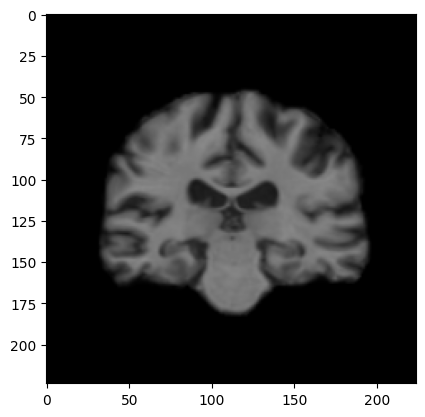

tensor(1)
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


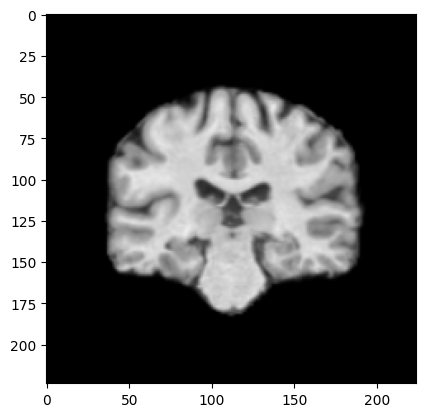

In [ ]:
# test_tensor
def custom_imshow(img):
  img = img.numpy()
  plt.imshow(np.transpose(img, (1,2,0)))
  plt.show()

test_tensor = []
def process():
  for batch_idx, (images, labels) in enumerate(test_loader):
    for i in range (30):
      print(labels[i])
      test_tensor.append(images[i])
      print(images[i])
      custom_imshow(images[i])
      if i == 1:
        break
    if batch_idx == 0:
      break

process()

# processor
test_tensor = processor(images=test_tensor, return_tensors="pt", padding=True, do_resize=False, do_rescale=False, do_normalize=False).to(DEVICE)

In [ ]:
# attention map 뽑기
imagename = 'test'
attention_rollout = VITAttentionRollout(model)
mask = attention_rollout(**test_tensor)
name = "/content/drive/MyDrive/2023 서울AI허브/Project/attention_rollout_{}.png".format(imagename)

torch.Size([128, 3, 49, 49])
torch.Size([128, 3, 49, 49])
torch.Size([32, 6, 49, 49])
torch.Size([32, 6, 49, 49])
torch.Size([8, 12, 49, 49])
torch.Size([8, 12, 49, 49])
torch.Size([8, 12, 49, 49])
torch.Size([8, 12, 49, 49])
torch.Size([8, 12, 49, 49])
torch.Size([8, 12, 49, 49])
torch.Size([2, 24, 49, 49])
torch.Size([2, 24, 49, 49])


In [ ]:
# attention layer 확인
attention_layer_name='attention'

for name, module in model.named_modules():
  if attention_layer_name in name:
      print(name)

pretrained_model.swin.encoder.layers.0.blocks.0.attention
pretrained_model.swin.encoder.layers.0.blocks.0.attention.self
pretrained_model.swin.encoder.layers.0.blocks.0.attention.self.query
pretrained_model.swin.encoder.layers.0.blocks.0.attention.self.key
pretrained_model.swin.encoder.layers.0.blocks.0.attention.self.value
pretrained_model.swin.encoder.layers.0.blocks.0.attention.self.dropout
pretrained_model.swin.encoder.layers.0.blocks.0.attention.output
pretrained_model.swin.encoder.layers.0.blocks.0.attention.output.dense
pretrained_model.swin.encoder.layers.0.blocks.0.attention.output.dropout
pretrained_model.swin.encoder.layers.0.blocks.1.attention
pretrained_model.swin.encoder.layers.0.blocks.1.attention.self
pretrained_model.swin.encoder.layers.0.blocks.1.attention.self.query
pretrained_model.swin.encoder.layers.0.blocks.1.attention.self.key
pretrained_model.swin.encoder.layers.0.blocks.1.attention.self.value
pretrained_model.swin.encoder.layers.0.blocks.1.attention.self.dropo

In [ ]:
np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)
cv2.imshow("Input Image", np_img)
cv2.imshow(name, mask)
cv2.imwrite("input.png", np_img)
cv2.imwrite(name, mask)
cv2.waitKey(-1)

In [ ]:
test_tensor

[tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

In [ ]:
# (2) AutoImageClassification
test_tensor1 = processor(images=test_tensor, return_tensors="pt", padding=True, do_normalize=False).to(DEVICE)
test_tensor2 = processor(images=test_tensor, return_tensors="pt", padding=True, do_resize=False, do_rescale=False, do_normalize=False).to(DEVICE)

In [ ]:
test_tensor2

{'pixel_values': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

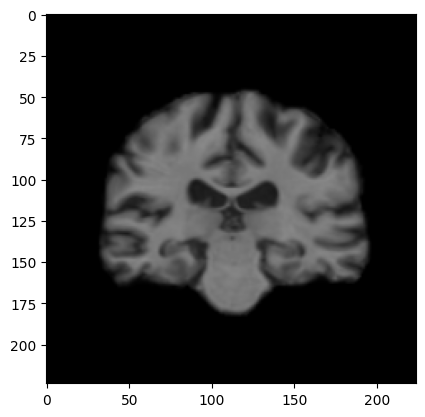

In [ ]:
test_tensor2.to(torch.device('cpu'))
custom_imshow(test_tensor2['pixel_values'][0])

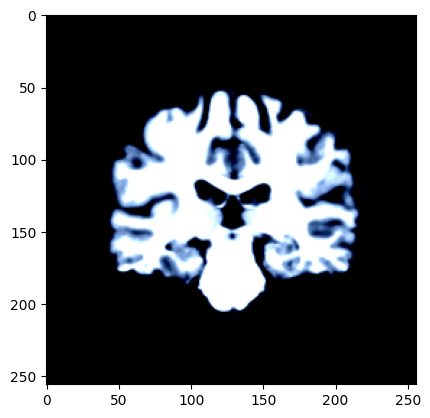

In [ ]:
custom_imshow(test_tensor['pixel_values'][1])

In [ ]:
test_tensor

{'pixel_values': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1

In [ ]:
#----------------------------------------------------------------------------------#

In [ ]:
# # Initialize Swin Transformer model and image processor
# model_name = "microsoft/swinv2-base-patch4-window16-256"
# processor = AutoImageProcessor.from_pretrained(model_name)
# model = AutoModelForImageClassification.from_pretrained(model_name)

# # model layer
# vit = processor.vit(permute)[0]
# classifier = tf.keras.layers.Dense(10, name='outputs')(vit[:, 0, :])

# # model
# model = tf.keras.Model(inputs=pixel_values, outputs=classifier)

# # define loss
# loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# # define metrics
# metrics=tf.keras.metrics.CategoricalAccuracy(name="accuracy")

# # compile model
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
#               loss=loss,
#               metrics=metrics)

In [ ]:
# if use_colab:
#     checkpoint_dir ='/content/drive/MyDrive/2023 서울AI허브/Project/train_ckpt/medical_baseline/exp1'
#     if not os.path.isdir(checkpoint_dir):
#         os.makedirs(checkpoint_dir)
# else:
#     checkpoint_dir = './train_ckpt/medical_baseline/exp1'

In [ ]:
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
#                                                      monitor='val_loss',
#                                                      restore_best_weights=True,
#                                                      verbose=1)

In [ ]:
# train_results = model.fit(
#     train_generator,
#     steps_per_epoch=len(train_data) // batch_size,
#     validation_data=test_generator,
#     validation_steps=len(test_data) // batch_size,
#     epochs=100,
#     callbacks=[early_stopping_cb]
# )

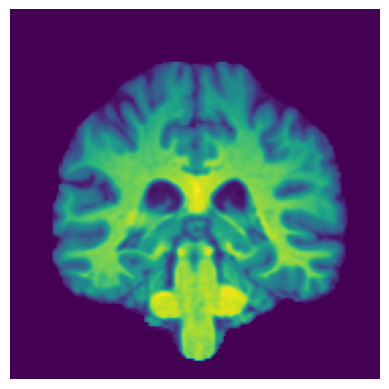

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ValueError: Unsupported number of image dimensions: 2

In [ ]:
# # Initialize Swin Transformer model and image processor
# model_name = "microsoft/swinv2-base-patch4-window16-256"
# processor = AutoImageProcessor.from_pretrained(model_name)
# model = AutoModelForImageClassification.from_pretrained(model_name)

# # Prepare your dataset
# train_dataset = CustomDataset(...)
# val_dataset = CustomDataset(...)

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)

# # Define loss function and optimizer
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     for ccc:
#         optimizer.zero_grad()
#         inputs = processor(images=inputs, return_tensors="pt", padding=True)
#         outputs = model(**inputs)
#         loss = criterion(outputs.logits, labels)
#         loss.backward()
#         optimizer.step()

#     # Validation
#     model.eval()
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs = processor(images=inputs, return_tensors="pt", padding=True)
#             outputs = model(**inputs)
#             val_loss = criterion(outputs.logits, labels)

#     print(f"Epoch {epoch + 1}: Train Loss {loss.item()}, Validation Loss {val_loss.item()}")

# # Evaluation on test set
# test_dataset = CustomDataset(...)
# test_loader = DataLoader(test_dataset, batch_size=32)
# model.eval()
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs = processor(images=inputs, return_tensors="pt", padding=True)
#         outputs = model(**inputs)
#         # Compute accuracy or other evaluation metrics




# inputs = processor(images=image, return_tensors="pt")
# outputs = model(**inputs)
# logits = outputs.logits
# # model predicts one of the 1000 ImageNet classes
# predicted_class_idx = logits.argmax(-1).item()

# print("Predicted class:", model.config.id2label[predicted_class_idx])

In [ ]:
# base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# pixel_values = tf.keras.layers.Input(shape=(224, 224, 3), dtype='float32')
# permute = tf.keras.layers.Permute((3, 1, 2))(pixel_values)

# # model layer
# vit = base_model.vit(permute)[0]
# classifier = tf.keras.layers.Dense(10, name='outputs')(vit[:, 0, :])

# # model
# model = tf.keras.Model(inputs=pixel_values, outputs=classifier)

# # define loss
# loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# # define metrics
# metrics=tf.keras.metrics.CategoricalAccuracy(name="accuracy")

# # compile model
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
#               loss=loss,
#               metrics=metrics)

In [ ]:
# img_path = base_path + '/MCI/002_S_0729_060802/plane0.png'
# # url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# # image = Image.open(requests.get(img_path, stream=True).raw)
# image = Image.open(img_path)

# plt.imshow(image)
# plt.axis("off")
# plt.show()

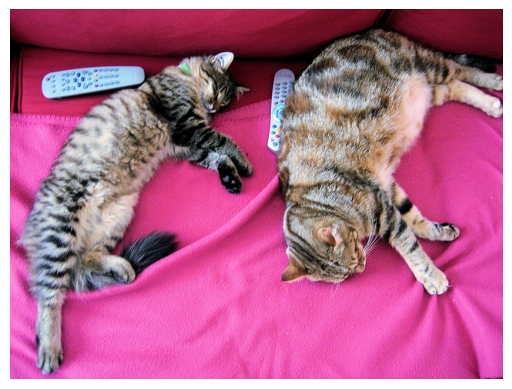

In [ ]:
# import matplotlib.pyplot as plt

# # Displaying the input image
# plt.imshow(image)
# plt.axis("off")
# plt.show()

In [ ]:
# import cv2
# from google.colab.patches import cv2_imshow

# print(input)
# print(image)
# img = cv2.imread("http://images.cocodataset.org/val2017/000000039769.jpg")
# cv2_imshow(img)

<bound method Kernel.raw_input of <google.colab._kernel.Kernel object at 0x7c20a48b7a60>>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7C1F7B9C7B80>


AttributeError: 'NoneType' object has no attribute 'clip'

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.dataframe = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         img_path = self.dataframe.iloc[idx, 0]  # Get image path from the dataframe
#         label = self.dataframe.iloc[idx, 1]     # Get label from the dataframe

#         # Load image
#         image = Image.open(img_path)

#         # Apply transformations if provided
#         if self.transform:
#             image = self.transform(image)

#         return image, label

# # Define transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to the desired size
#     transforms.ToTensor(),           # Convert images to tensors
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
# ])

# # Create dataset instances
# train_dataset = CustomDataset(train_df, transform=transform)
# valid_dataset = CustomDataset(valid_df, transform=transform)
# test_dataset = CustomDataset(test_df, transform=transform)

# # Create data loaders
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)